# DSCI 592: Data Science Capstone II <br> Wildfire By-Pixel Object Detection - From-Scratch UNET Model

## Model Objective
1. Ability to receive still images / video footage from UAV (Unmanned Aerial Vehicle)
2. Ability to process still images / video footage for modeling
3. Ability to detect forest fire on a by-pixel level (giving us the size and shape)

## Dataset(s) Used
1. FLAME 1 Dataset - "FIRE BOUNDARY DATASET"
    - Consists of RGB .jpg and image mask pairs
    - 2,003 image pairs in total
    - Images initially sized 2,160 x 3,840

## Import Relevant libraries

First, we will import the libraries needed for our model development. These will be broken up by their uses.

In [1]:
#Importing and reading images
from pathlib import Path
import cv2
import os
import re
from PIL import Image
from tqdm import tqdm

#General Utility
import random
import pandas as pd
import numpy as np

#Modeling - General
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model

#Modeling - Layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

#Modeling - Analysis / Evaluation
from tensorflow.keras.models import load_model
from skimage.io import imshow
import matplotlib.pyplot as plt

## Import and Prepare Dataset

In [2]:
### Global Variable Setting ###

#Directory paths:
dir_images = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Summer 2023\\DSCI 592\\Datasets\\FLAME 1\\Images"
dir_masks = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Summer 2023\\DSCI 592\\Datasets\\FLAME 1\\Masks"

#Image Sizing data:
img_size = (512, 512)
img_width = 512
img_height = 512
img_channels = 3

#Training data:
batch_size = 16
epochs = 30
num_classes = 2

In [3]:
### Establishing Paths ###

#Establish paths to images
allfiles_image = sorted(
    [
        os.path.join(dir_images, fname)
        for fname in tqdm(os.listdir(dir_images))
        if fname.endswith(".jpg")
    ]
)

#Establish paths for masks
allfiles_mask = sorted(
    [
        os.path.join(dir_masks, fname)
        for fname in tqdm(os.listdir(dir_masks))
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

100%|██████████| 2003/2003 [00:00<00:00, 183020.52it/s]


In [4]:
#Get total number of samples
total_samples = len(allfiles_mask)

#Establish split (80% Test, 10% Val, 10% Test)
val_samples_start = int(total_samples * (0.8))
test_samples_start = int(total_samples * (0.9))

#Shuffle images (but replicable)
random.Random(1337).shuffle(allfiles_image)
random.Random(1337).shuffle(allfiles_mask)

In [5]:
#Set paths - TRAIN
train_img_paths = allfiles_image[:val_samples_start]
train_mask_paths = allfiles_mask[:val_samples_start]

#Set paths - VAL
val_img_paths = allfiles_image[val_samples_start:test_samples_start]
val_mask_paths = allfiles_mask[val_samples_start:test_samples_start]

#Set paths - TEST
test_img_paths = allfiles_image[test_samples_start:]
test_mask_paths = allfiles_mask[test_samples_start:]

In [6]:
### TRAINING ###
x_train = np.zeros((len(train_img_paths), img_height, img_width, img_channels), dtype=np.uint8)
y_train = np.zeros((len(train_mask_paths), img_height, img_width, 1), dtype=bool)

#LOAD - Training Images
for n, file_ in tqdm(enumerate(train_img_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size)
    x_train[n] = img

#LOAD - Training Masks
for n, file_ in tqdm(enumerate(train_mask_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size, color_mode="grayscale")
    y_train[n] = np.expand_dims(img, axis=2)

1602it [03:27,  7.72it/s]
1602it [00:41, 38.79it/s]


In [7]:
### VALIDATION ###
x_val = np.zeros((len(val_img_paths), img_height, img_width, img_channels), dtype=np.uint8)
y_val = np.zeros((len(val_mask_paths), img_height, img_width, 1), dtype=bool)

#LOAD - Validation Images
for n, file_ in tqdm(enumerate(val_img_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size)
    x_val[n] = img

#LOAD - Validation Masks
for n, file_ in tqdm(enumerate(val_mask_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size, color_mode="grayscale")
    y_val[n] = np.expand_dims(img, axis=-1)

200it [00:25,  7.77it/s]
200it [00:05, 39.08it/s]


In [8]:
### TEST ###
x_test = np.zeros((len(test_img_paths), img_height, img_width, img_channels), dtype=np.uint8)
y_test = np.zeros((len(test_mask_paths), img_height, img_width, 1), dtype=bool)

#LOAD - Test Images
for n, file_ in tqdm(enumerate(test_img_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size)
    x_test[n] = img

#LOAD - Test Masks
for n, file_ in tqdm(enumerate(test_mask_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size, color_mode="grayscale")
    y_test[n] = np.expand_dims(img, axis=-1)

201it [00:29,  6.71it/s]
201it [00:06, 29.71it/s]


## Establishing Model Architecture

The model we are creating is based off this paper, a DCNN for medical image segmentation: https://arxiv.org/abs/1505.04597.

Specifically, a similar implementation has already been completed in the following paper: https://www.sciencedirect.com/science/article/pii/S1389128621001201?ref=cra_js_challenge&fr=RR-1.

In [11]:
def make_unet_model(img_height, img_width, img_channel, num_classes):
    inputs = Input((img_height, img_width, img_channel))
    s = Lambda(lambda x: x / 255)(inputs)

    #Block 1 - Contracting
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    #Block 2 - Contracting
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    #Block 3 - Contracting
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    #Block 4 - Contracting
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    #Block 5 - Bottleneck Block
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    #Block 6 - Upsample (Block 5 x Block 4)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    #Block 7 - Upsample (Block 6 x Block 3)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    #Block 8 - Upsample (Block 7 x Block 2)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    #Block 9 - Upsample (Block 8 x Block 1)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## Compiling & Training Model

In [10]:
METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryIoU(name='IoU'),
    tf.keras.metrics.BinaryAccuracy(name='bin_accuracy')
]

In [12]:
#Call model construction
unet_model = make_unet_model(img_height, img_width, img_channels, num_classes)

#Compile model
unet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)

#Set up model checkpoints and early stopping
checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_object_detection_unet.h5", save_best_only=True)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5)

In [13]:
#Fit model to training dataset
fitted_unet_model = unet_model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                                   epochs = epochs, batch_size = batch_size, callbacks = [early_stopper, checkpoint])

Epoch 1/30
101/101 [==============================] - 1688s 17s/step - loss: 0.0551 - auc: 0.6534 - tp: 122696.0000 - tn: 413515264.0000 - fp: 3961759.0000 - fn: 2354982.0000 - precision: 0.0300 - recall: 0.0495 - IoU: 0.5020 - bin_accuracy: 0.9850 - val_loss: 0.0335 - val_auc: 0.6672 - val_tp: 12.0000 - val_tn: 52126292.0000 - val_fp: 0.0000e+00 - val_fn: 302500.0000 - val_precision: 1.0000 - val_recall: 3.9668e-05 - val_IoU: 0.4971 - val_bin_accuracy: 0.9942
Epoch 2/30
101/101 [==============================] - 1621s 16s/step - loss: 0.0139 - auc: 0.9342 - tp: 1366309.0000 - tn: 417261120.0000 - fp: 215899.0000 - fn: 1111369.0000 - precision: 0.8635 - recall: 0.5514 - IoU: 0.7520 - bin_accuracy: 0.9968 - val_loss: 0.0104 - val_auc: 0.9443 - val_tp: 199763.0000 - val_tn: 52095748.0000 - val_fp: 30543.0000 - val_fn: 102749.0000 - val_precision: 0.8674 - val_recall: 0.6603 - val_IoU: 0.7986 - val_bin_accuracy: 0.9975
Epoch 3/30
101/101 [==============================] - 4260s 42s/step -

Epoch 19/30
101/101 [==============================] - 1173s 12s/step - loss: 0.0031 - auc: 0.9988 - tp: 2174014.0000 - tn: 417247648.0000 - fp: 229315.0000 - fn: 303664.0000 - precision: 0.9046 - recall: 0.8774 - IoU: 0.9009 - bin_accuracy: 0.9987 - val_loss: 0.0042 - val_auc: 0.9908 - val_tp: 249307.0000 - val_tn: 52103672.0000 - val_fp: 22615.0000 - val_fn: 53205.0000 - val_precision: 0.9168 - val_recall: 0.8241 - val_IoU: 0.8827 - val_bin_accuracy: 0.9986
Epoch 20/30
101/101 [==============================] - 1166s 12s/step - loss: 0.0031 - auc: 0.9989 - tp: 2176206.0000 - tn: 417250048.0000 - fp: 226983.0000 - fn: 301472.0000 - precision: 0.9055 - recall: 0.8783 - IoU: 0.9017 - bin_accuracy: 0.9987 - val_loss: 0.0038 - val_auc: 0.9960 - val_tp: 274493.0000 - val_tn: 52075720.0000 - val_fp: 50565.0000 - val_fn: 28019.0000 - val_precision: 0.8444 - val_recall: 0.9074 - val_IoU: 0.8880 - val_bin_accuracy: 0.9985
Epoch 21/30
101/101 [==============================] - 1167s 12s/step - 

In [14]:
def plot_training(history, type_model, layers_len):
    (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))
    epochs = len(history.history['bin_accuracy'])
    ax[0].set_title("Accuracy", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[0].set_ylabel("Accuracy", fontsize=14, fontweight="bold")
    ax[0].plot(np.arange(1, epochs+1), history.history['bin_accuracy'], label='Accuracy', linewidth=2.5, linestyle='-', marker='o',
               markersize='10', color='red')
    ax[0].plot(np.arange(1, epochs+1), history.history['val_bin_accuracy'], label='Validation_accuracy', linewidth=2.5, marker='x',
               linestyle='--', markersize='10', color='blue')
    ax[0].grid(True)
    ax[0].legend(prop={'size': 14, 'weight': 'bold'})
    ax[0].tick_params(axis='both', which='major', labelsize=15)

    plt.subplots_adjust(hspace=0.3)

    ax[1].set_title("IoU", fontsize=14, fontweight="bold")
    ax[1].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[1].set_ylabel("IoU", fontsize=14, fontweight="bold")
    ax[1].plot(np.arange(1, epochs+1), history.history['IoU'], label='IoU', linewidth=2.5, linestyle='-',
               marker='o', markersize='10', color='red')
    ax[1].plot(np.arange(1, epochs+1), history.history['val_IoU'], label='Validation_IoU', linewidth=2.5,
               linestyle='--', marker='x', markersize='10', color='blue')
    ax[1].grid(True)
    ax[1].legend(prop={'size': 14, 'weight': 'bold'}, loc='best')
    ax[1].tick_params(axis='both', which='major', labelsize=15)

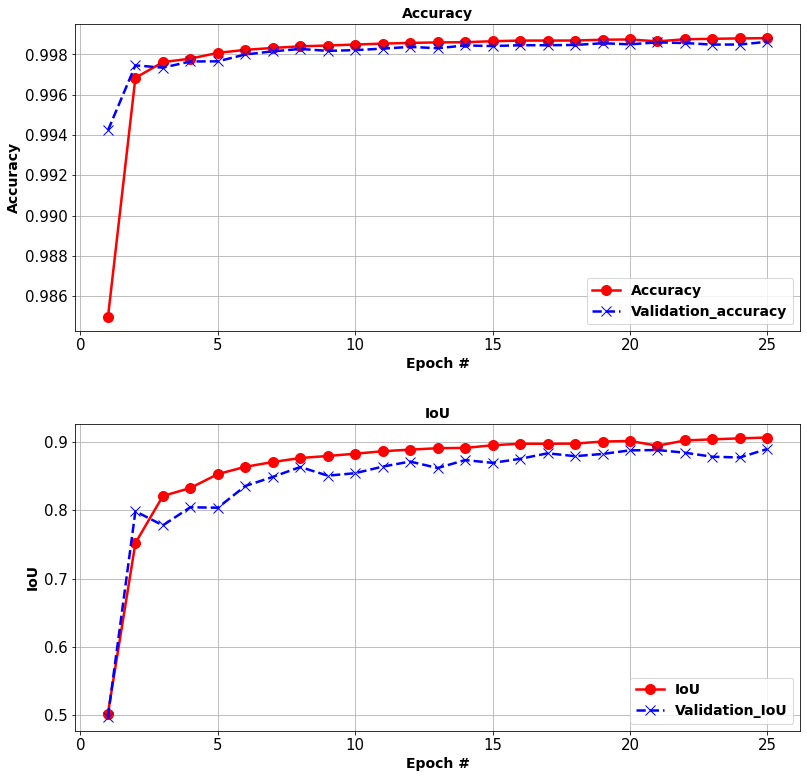

In [15]:
#Grab length of layers for plotting
layers_len = len(unet_model.layers)

#Plot results of training
plot_training(fitted_unet_model, 'KerasModel', layers_len)

In [16]:
#Save model
unet_model.save('model_fire_pixel_detection_unet_V3')

INFO:tensorflow:Assets written to: model_fire_pixel_detection_unet_V3\assets


INFO:tensorflow:Assets written to: model_fire_pixel_detection_unet_V3\assets


## Evaluating Results of Model on Test

In [20]:
#Load model, if needed
unet_model = tf.keras.models.load_model("model_fire_pixel_detection_unet_V3")

In [17]:
### General Test Function Definition
def test_by_pixel_object_detection(x_test, y_test, model):
    results_eval = model.evaluate(x_test, y_test, batch_size = batch_size)

    for name, value in zip(model.metrics_names, results_eval):
        print(name, ': ', value)
    print()

    return results_eval

In [18]:
#Call function to test model
test_by_pixel_object_detection(x_test, y_test, unet_model)

13/13 [==============================] - 34s 3s/step - loss: 0.0035 - auc: 0.9923 - tp: 249252.0000 - tn: 52375188.0000 - fp: 25363.0000 - fn: 41142.0000 - precision: 0.9076 - recall: 0.8583 - IoU: 0.8941 - bin_accuracy: 0.9987
loss :  0.003501992905512452
auc :  0.9923283457756042
tp :  249252.0
tn :  52375188.0
fp :  25363.0
fn :  41142.0
precision :  0.907641589641571
recall :  0.8583235144615173
IoU :  0.8940554857254028
bin_accuracy :  0.9987378716468811



[0.003501992905512452,
 0.9923283457756042,
 249252.0,
 52375188.0,
 25363.0,
 41142.0,
 0.907641589641571,
 0.8583235144615173,
 0.8940554857254028,
 0.9987378716468811]

In [19]:
#Derive F1 Score
Precision = 0.9192538857460022
Recall = 0.8584027290344238
F1 = 2 * (Precision * Recall) / (Precision + Recall)
print("F1 : ", F1)

F1 :  0.8877868061119714


The binary accuracy and precision/recall are quite high for this model! The accuraccy is especially high, which leads us to investigate further. The IoU sheds light on this, as [it measures the overlap between the predicted and the actual object](https://encord.com/glossary/iou-definition/). Here, we see that the value is just under 0.89, meaning that the overlap is very high. So, we can definitively say that the model performs very well in this task.

In [20]:
#Create a test function to plot specific images
def plot_segmentation_test(x_test, y_test, y_pred, num_samples):
    #Establish figure size
    fig = plt.figure(figsize=(14, 12))
    
    #Iterate through samples
    for i in range(0, num_samples):
        
        #Create subplot for Base Image
        plt.subplot(3, num_samples, (0 * num_samples) + i + 1)
        ix_test = random.randint(0, len(y_pred) - 1)
        title = str(i+1)
        plt.title(title)
        imshow(x_test[ix_test])
        plt.axis('off')

        #Create subplot for GROUND TRUTH Mask
        plt.subplot(3, num_samples, (1 * num_samples) + i + 1)
        plt.imshow(np.squeeze(y_test[ix_test]))
        plt.title('GROUND TRUTH Mask')
        plt.axis('off')

        #Create subplot for PREDICTED Mask
        plt.subplot(3, num_samples, (2 * num_samples) + i + 1)
        plt.imshow(np.squeeze(y_pred[ix_test]))
        plt.title('PREDICTED Mask')
        plt.axis('off')

7/7 [==============================] - 31s 4s/step


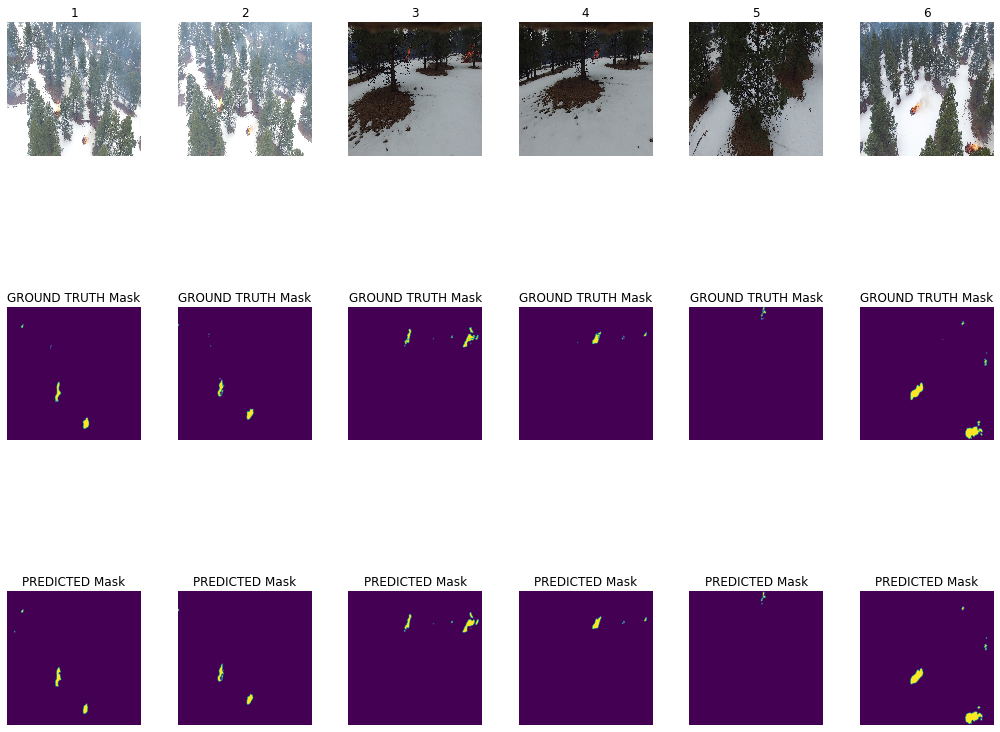

In [21]:
#Predict and create thresholds for X Test data
y_pred = unet_model.predict(x_test, verbose=1)
y_preds_t = (y_pred > 0.5).astype(np.uint8)

plot_segmentation_test(x_test = x_test, y_test = y_test, y_pred = y_preds_t, num_samples = 6)

We can see how closely - at an image level - the PREDICTED mask lines up with the GROUND TRUTH mask.